# Brazilian Securities

---

### Wilson Freitas


# Brazilian Securities

---

### Wilson Freitas

# Lecture 2

- Flat-forward interpolation with COPOM Meetings
- Treasury Direct contracts
	- Floating: LFT
	- Fixed: LTN, NTN-F
	- Indexed: NTN-B, Bullet NTN-B
- ANBIMA Data
- Bootstrap
- Nelson-Siegel coeficients ANBIMA
- Implied Inflation

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bcb import currency, sgs
import bizdays

import myfuncs as my

## DI x PRE Curve

In [51]:
df = pd.read_parquet('data/contracts_202109_202111.parquet').reset_index(drop=True)

In [52]:
di1 = df[(df['Mercadoria'] == 'DI1') &
         (df['PUAtual'] != 100000.0) &
         (df['DataRef'] == pd.to_datetime('2021-11-01'))].copy()

In [53]:
MARKET_CALENDAR = bizdays.Calendar.load('ANBIMA.cal')
di1['Maturity'] = di1['Vencimento'].map(MARKET_CALENDAR.following)
di1['DU'] = di1.apply(lambda x: MARKET_CALENDAR.bizdays(x['DataRef'], x['Maturity']), axis=1)
di1['Rate'] = (100000 / di1['PUAtual'])**(252 / di1['DU']) - 1
di1_curve = di1[['DataRef', 'Maturity', 'DU', 'Rate']]

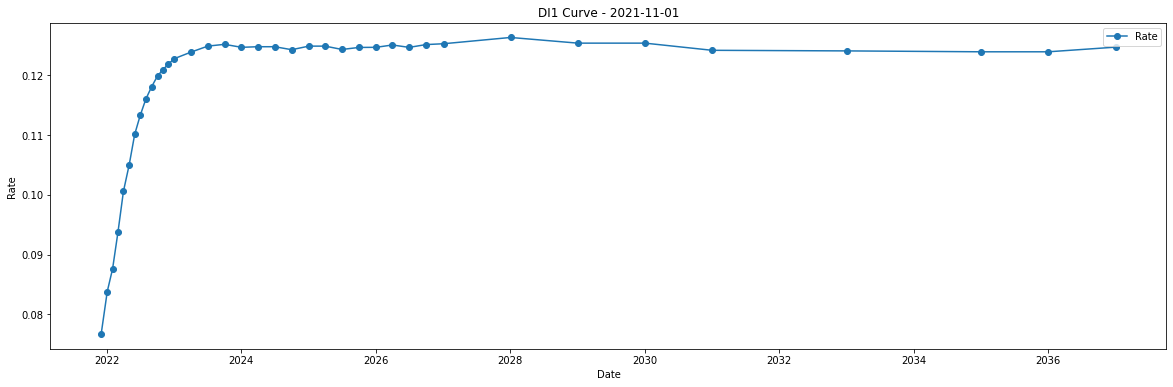

In [54]:
di1_curve.plot(x='Maturity', y='Rate', figsize=(20,6), style='-o',
               ylabel='Rate', xlabel='Date', title='DI1 Curve - 2021-11-01');

### Completing the curve with daily CDI

In [55]:
di1_curve_h = di1_curve.reset_index(drop=True).head()

In [56]:
cdi = sgs.get(('CDI', 4389), start_date='2021-11-01', end_date='2021-11-01')

In [57]:
first_term = pd.DataFrame({
    'DataRef': datetime.datetime(2021,11,1),
    'Maturity': ['2021-11-03'],
    'DU': [1],
    'Rate': [cdi.iloc[0, 0]/100]
})

In [58]:
di1_curve_h = pd.concat([first_term, di1_curve_h], axis=0).reset_index(drop=True)
di1_curve_h['DataRef'] = pd.to_datetime(di1_curve_h['DataRef'])
di1_curve_h

,DataRef,Maturity,DU,Rate
0,2021-11-01,2021-11-03,1,0.07650
1,2021-11-01,2021-12-01,20,0.07670
2,2021-11-01,2022-01-03,43,0.08380
3,2021-11-01,2022-02-01,64,0.08762
4,2021-11-01,2022-03-02,83,0.09371
5,2021-11-01,2022-04-01,105,0.10060


### Exponential Flat Forward Interpolation

In [59]:
log_pu = np.log((1 + di1_curve_h['Rate'])**(di1_curve_h['DU']/252))
terms = di1_curve_h['DU']
i_terms = np.array(range(terms.min(), terms.max()))
pu = np.exp(np.interp(i_terms, terms, log_pu))
i_curve = pd.DataFrame({
    'DU': i_terms,
    'Maturity': MARKET_CALENDAR.vec.offset('2021-11-01', i_terms),
    'Rate': pu ** (252 / i_terms) - 1
})

In [60]:
i_curve['Factor'] = (1 + i_curve['Rate'])**(i_curve['DU']/252)
i_curve['Factor_p'] = i_curve['Factor'].shift(1)
i_curve['FwdRate'] = (i_curve['Factor']/i_curve['Factor_p'])**252 - 1

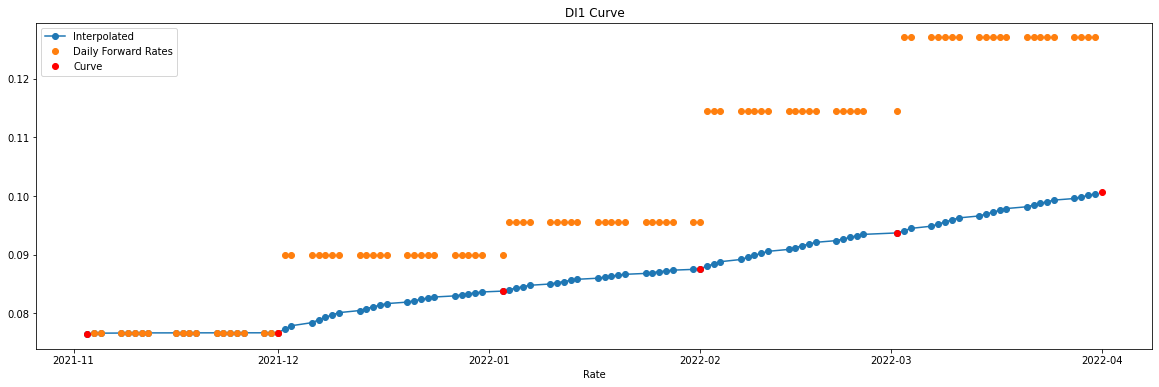

In [61]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(i_curve['Maturity'], i_curve['Rate'], '-o')
plt.plot(i_curve['Maturity'], i_curve['FwdRate'], 'o')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['Interpolated', 'Daily Forward Rates', 'Curve'])
plt.show()

## COPOM Meetings

In [62]:
rates = sgs.get(dict(SELICTARGET=432, CDI=4389), start_date='2021-09-01', end_date='2021-12-31')

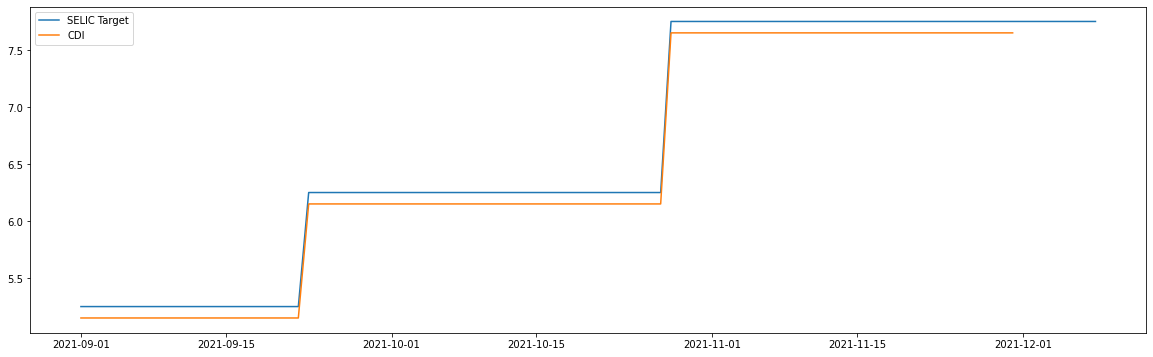

In [63]:
plt.figure(figsize=(20,6))
plt.plot(rates[0].index, rates[0]);
plt.plot(rates[1].index, rates[1]);
plt.legend(['SELIC Target', 'CDI']);

In the same chart:

- Historical SELIC Target
- Daily Forward Rates

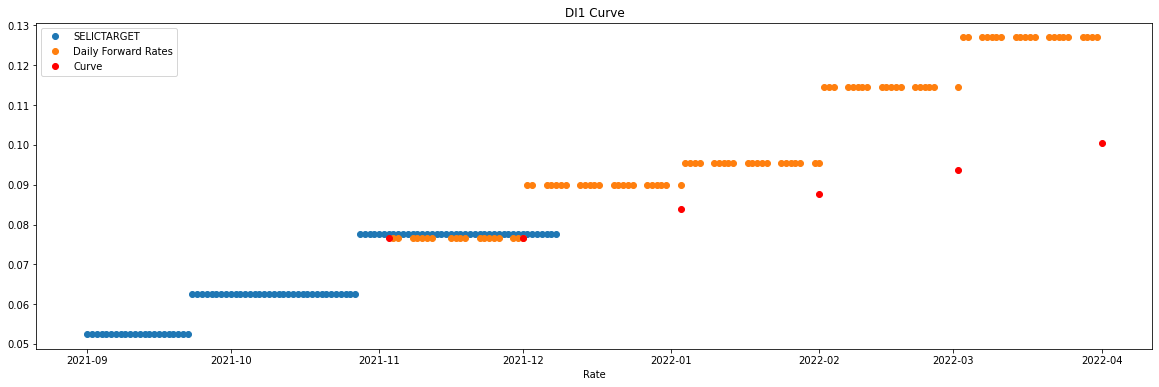

In [64]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(rates[0].index, rates[0]/100, 'o')
plt.plot(i_curve['Maturity'], i_curve['FwdRate'], 'o')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['SELICTARGET', 'Daily Forward Rates', 'Curve'])
plt.show()

### COPOM Meetings considerations

* Is is a good idea to consider the COPOM Meetings in the interpolation.
* Specially the **first meeting** that is more clear and presents a direct result.


### Define the rates before the COPOM Meeting

* On 2021-11-01, the next COPOM Meeting occurs at 2021-12-08.
* Up to the next meeting, the interpolation must consider the current CDI rate available.
* The first future matures at 2021-12-01 (Z21), before the first meeting.
    * Its price might be slightly different.
    * Once we don't have any new information, the CDI must be kept.

In [65]:
i_curve['COPOM_Rate'] = np.nan
_cdi = cdi.values[0, 0]/100
i_curve.loc[i_curve['Maturity'] <= pd.to_datetime('2021-12-08'), 'COPOM_Rate'] = _cdi

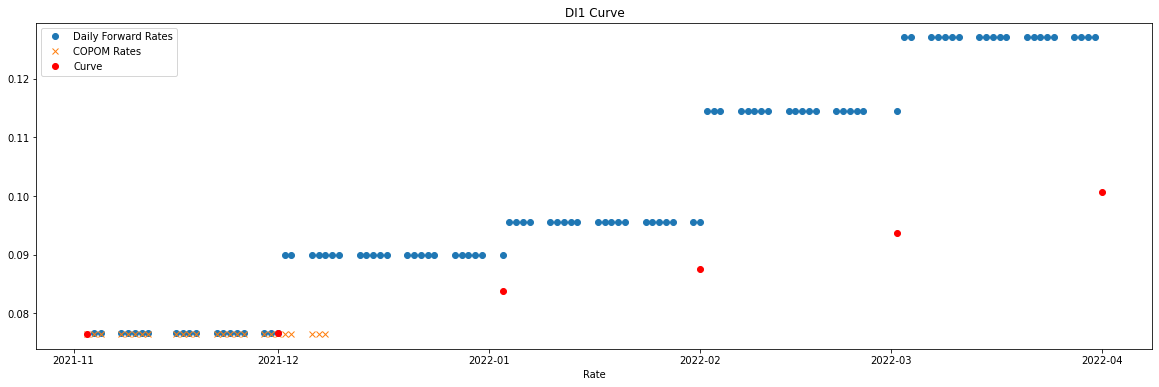

In [66]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(i_curve['Maturity'], i_curve['FwdRate'], 'o')
plt.plot(i_curve['Maturity'], i_curve['COPOM_Rate'], 'x')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['Daily Forward Rates', 'COPOM Rates', 'Curve'])
plt.show()

### Define the rates after the COPOM Meeting

* The second furure expires at 2022-01-01 (F22) is influenced by the decision taken on the this next meeting.

* The spot rate $r(t, T)$ reffers to the second future and can be written as

$$
(1 + r(t,T))^{DU(t,T)/252} = (1 + CDI_t)^{DU(t,C)/252} (1 + CDI_{a})^{DU(C,T)/252}
$$

where

- $C$: COPOM Meeting Date
- $CDI_t$: current CDI rate
- $CDI_a$: the expected CDI rate after the meeting

In [67]:
f22_rate = di1.loc[di1['CDVencimento'] == 'F22', 'Rate'].values[0]
f22_DU = di1.loc[di1['CDVencimento'] == 'F22', 'DU'].values[0]
C_DU = MARKET_CALENDAR.bizdays('2021-11-01', '2021-12-08')

f1 = (1 + f22_rate) ** (f22_DU/252)
f2 = (1 + _cdi) ** (C_DU/252)

rate_C = (f1 / f2) ** (252 / (f22_DU - C_DU)) - 1

In [68]:
ix = (pd.to_datetime('2021-12-08') < i_curve['Maturity']) & \
     (i_curve['Maturity'] <= pd.to_datetime('2022-01-03'))
i_curve.loc[ix, 'COPOM_Rate'] = rate_C

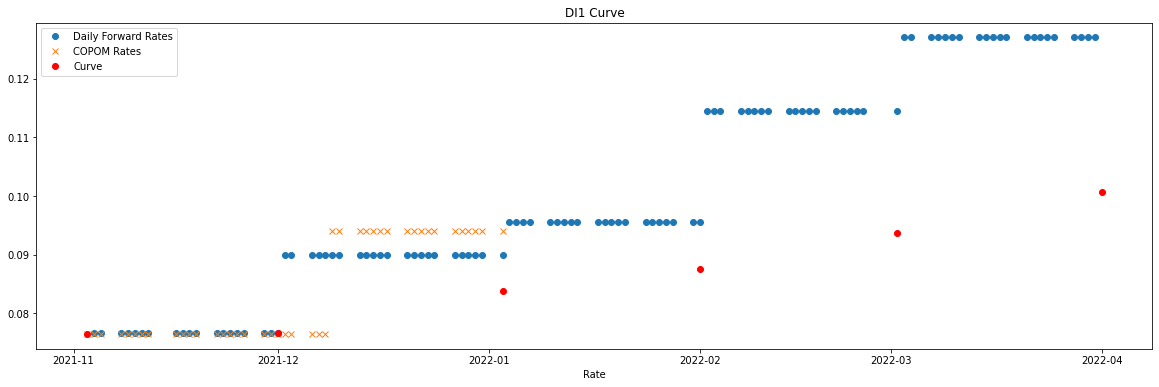

In [69]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('DI1 Curve')
plt.plot(i_curve['Maturity'], i_curve['FwdRate'], 'o')
plt.plot(i_curve['Maturity'], i_curve['COPOM_Rate'], 'x')
plt.plot(pd.to_datetime(di1_curve_h['Maturity']), di1_curve_h['Rate'], 'o', color='red');
plt.legend(['Daily Forward Rates', 'COPOM Rates', 'Curve'])
plt.show()

### COPOM decision implied in the future

* By the price of the future, we can see that the decision, that will be taken in the COPOM Meeting, is implied in the future price

$$
(1 + r(t,T))^{DU(t,T)/252} = (1 + CDI_t)^{DU(t,C)/252} (1 + CDI_{t} + u)^{DU(C,T)/252}
$$

where

* $u$: the change in the spot rate announced in the COPOM Meeting

In [70]:
f22_rate = di1.loc[di1['CDVencimento'] == 'F22', 'Rate'].values[0]
f22_DU = di1.loc[di1['CDVencimento'] == 'F22', 'DU'].values[0]
C_DU = MARKET_CALENDAR.bizdays('2021-11-01', '2021-12-08')

f1 = (1 + f22_rate) ** (f22_DU/252)
f2 = (1 + _cdi) ** (C_DU/252)

change = (f1 / f2) ** (252 / (f22_DU - C_DU)) - 1 - _cdi

print(change * 1e4, 'change in the spot rate (SELICTARGET) in bps')

175.20749160745655 change in the spot rate (SELICTARGET) in bps


## Tesouro Direto -- Government Bonds

* Government Bonds are daily traded in the Tesouro Direto

* Contracts traded in Tesouro Direto
    * LFT: Floating Rate Note
    * LTN: Fixed Rate Note
    * NTN-F: Fixed Rate Note with Coupons
    * NTN-B: Inflation Indexed with Coupons
    * NTN-B Principal: Inflation Indexed Bullet Bond


### LFT

* LFT - Letra Financeira do Tesouro is a **Floating Rate Bond**.
    * It is a bullet bond, has no coupon payments.


#### Present Value

$$
LFT = \frac{VNA}{(1 + s)^{DU/252}}
$$

$$
VNA = 1000 \prod_{n=1}^T(1 + SELIC_{n})^{1/252}
$$


* $s$: small spread that is paid to enter in this contract
    * $s$ can be treated as an risk factor, but unfortunately this is not *headgeable*, and also tiny.
* $VNA$: Valor Nominal Atualizado - *Notional Accrued*
    * $VNA$ is what the investor receives at maturity



* <https://www.anbima.com.br/pt_br/informar/valor-nominal-atualizado.htm>

![](images/VNA_LFT_20211101.png)



### LTN

* LTN - Letra do Tesouro Nacional is a **Fixed Rate Bond**.
    * It is a bullet bond, has no coupon payments

<!-- ![](images/fluxo-de-caixa-ltn.png) -->
<img src="images/fluxo-de-caixa-ltn.png" width="600">

#### Present Value

$$
VP_t = \frac{1000}{(1 + y_t)^T}
$$



### NTN-F

* NTN-F - Nota Financeira do Tesouro Série F is a **Fixed Rate Bond**.
    * It has semi annual coupon payments.

<!-- ![](images/fluxo-de-caixa-ntnf.png) -->
<img src="images/fluxo-de-caixa-ntnf.png" width="800">

#### Present Value

$$
VP_t = \sum_{k=1}^{N}\frac{1000\cdot[(1.10)^{0.5}-1]}{(1+y_t)^{t_k}} + \frac{1000}{(1 + y_t)^{t_N}}
$$

### NTN-B

* NTN-F - Nota Financeira do Tesouro Série B is a **Fixed Rate Bond**.
    * It has semi annual coupon payments.
    * It is indexed to IPCA index (inflation index).
    * It pays the inflation during a period plus an interest rate.

<!-- <div style="max-width:400px;margin-left: auto; margin-right: 0;">
    ![](images/fluxo-de-caixa-ntnb.png)
</div> -->
<img src="images/fluxo-de-caixa-ntnb.png" width="700">


#### Present Value

$$
VP_t = \sum_{k=1}^{N}\frac{VNA_t\cdot[(1.06)^{0.5}-1]}{(1+y_t)^{t_k}} + \frac{VNA_t}{(1 + y_t)^{t_N}}
$$

* $VNA_t$: is indexed to IPCA inflation index.

* <https://www.anbima.com.br/pt_br/informar/valor-nominal-atualizado.htm>

![](images/VNA_NTN-B_20211101.png)



### NTN-B Principal

* NTN-B  Nota Financeira do Tesouro Série B is a **Fixed Rate Bond**.
    * It is a bullet bond, has no coupon payments.
    * This bond is mostly traded in retail, actually it has been striped from NTN-B bonds.

<!-- ![](images/fluxo-de-caixa-ntnb-principal.png) -->
<img src="images/fluxo-de-caixa-ntnb-principal.png" width="600">

#### Present Value

$$
VP_t = \frac{VNA_t}{(1 + c_t)^T}
$$


### Data

* <https://www.anbima.com.br/pt_br/informar/valor-nominal-atualizado.htm>

* <https://www.anbima.com.br/pt_br/informar/taxas-de-titulos-publicos.htm>

* <https://www.tesourodireto.com.br/titulos/precos-e-taxas.htm>


In [71]:
df = pd.read_parquet('data/2021-11-01.parquet')

In [72]:
df

,symbol,refdate,cod_selic,issue_date,maturity_date,bid_yield,ask_yield,ref_yield,price
0,LTN,2021-11-01,100000,2018-01-05,2022-01-01,8.3786,8.3490,8.3700,986.377808
1,LTN,2021-11-01,100000,2020-01-03,2022-04-01,10.0547,10.0280,10.0447,960.902954
2,LTN,2021-11-01,100000,2018-06-21,2022-07-01,11.3245,11.3034,11.3150,931.427257
3,LTN,2021-11-01,100000,2020-07-03,2022-10-01,11.9885,11.9672,11.9797,901.074386
4,LTN,2021-11-01,100000,2016-01-20,2023-01-01,12.3164,12.3025,12.3092,873.337504
5,LTN,2021-11-01,100000,2019-04-05,2023-07-01,12.5288,12.5172,12.5230,822.251181
6,LTN,2021-11-01,100000,2020-01-03,2024-01-01,12.5514,12.5400,12.5450,775.183013
7,LTN,2021-11-01,100000,2021-01-08,2024-07-01,12.5575,12.5419,12.5511,731.284206
8,LTN,2021-11-01,100000,2018-02-01,2025-01-01,12.5426,12.5223,12.5317,688.387569
9,NTN-C,2021-11-01,770100,2000-07-01,2031-01-01,5.6433,3.6057,4.4585,9395.480705


### PREFIXADO Curve

* LTN contracts plus SELIC rate are used to build a risk free term structure.

In [73]:
ltn = df[df['symbol'] == 'LTN'].copy()

ltn['fixing'] = ltn['maturity_date'].map(MARKET_CALENDAR.following)
ltn['DU'] = list(MARKET_CALENDAR.vec.bizdays(ltn['refdate'], ltn['fixing']))

ltn_terms = ltn[['refdate', 'maturity_date', 'DU', 'ref_yield']]

selic = sgs.get({'SELIC': 1178}, start_date='2021-11-01', end_date='2021-11-01')
first_term = pd.DataFrame({
    'refdate': ['2021-11-01'],
    'maturity_date': ['2021-11-03'],
    'DU': [1],
    'ref_yield': [selic.iloc[0, 0]]
})

ltn_curve = pd.concat([first_term, ltn_terms], axis=0).reset_index(drop=True)

In [74]:
ltn_curve

,refdate,maturity_date,DU,ref_yield
0,2021-11-01,2021-11-03,1,7.6500
1,2021-11-01,2022-01-01,43,8.3700
2,2021-11-01,2022-04-01,105,10.0447
3,2021-11-01,2022-07-01,167,11.3150
4,2021-11-01,2022-10-01,232,11.9797
5,2021-11-01,2023-01-01,294,12.3092
6,2021-11-01,2023-07-01,418,12.5230
7,2021-11-01,2024-01-01,543,12.5450
8,2021-11-01,2024-07-01,667,12.5511
9,2021-11-01,2025-01-01,797,12.5317


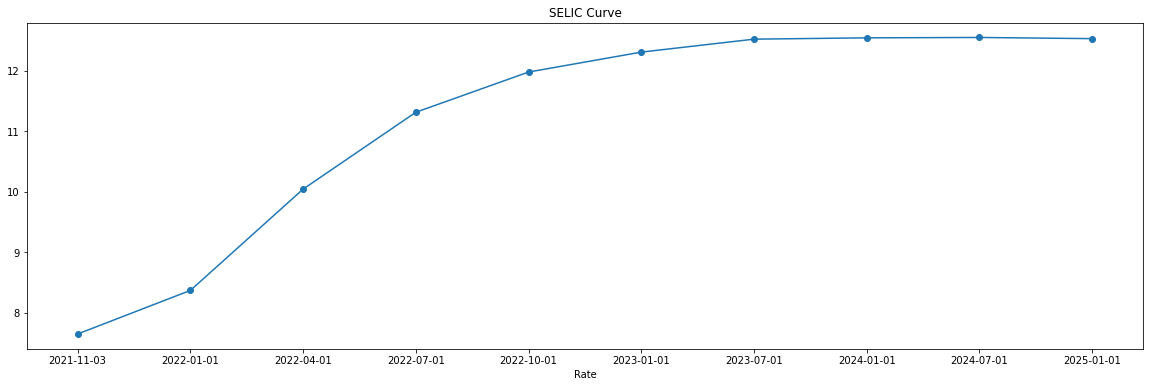

In [75]:
plt.figure(figsize=(20,6))
plt.xlabel('Rate')
plt.title('SELIC Curve')
plt.plot(ltn_curve['maturity_date'], ltn_curve['ref_yield'], '-o')
plt.show()

### Divergences with NTN-F contracts

* NTN-F and LTN are Fixed Rate Bonds, in order that they rely on the same risk structure and must be priced with the same curve.
* Instead, once NTN-F bonds are priced with LTN rates, it presents small divergences.

In [76]:
ntnfs = df[df['symbol'] == 'NTN-F'].copy()
ntnfs

,symbol,refdate,cod_selic,issue_date,maturity_date,bid_yield,ask_yield,ref_yield,price
35,NTN-F,2021-11-01,950199,2012-03-09,2023-01-01,12.3190,12.3025,12.3100,1009.002558
36,NTN-F,2021-11-01,950199,2014-01-10,2025-01-01,12.4460,12.4320,12.4399,973.304745
37,NTN-F,2021-11-01,950199,2016-01-15,2027-01-01,12.4480,12.4143,12.4273,946.436967
38,NTN-F,2021-11-01,950199,2018-01-05,2029-01-01,12.4735,12.4427,12.4538,924.491356
39,NTN-F,2021-11-01,950199,2020-01-10,2031-01-01,12.3185,12.2986,12.3103,914.086234


In [77]:
ltn

,symbol,refdate,cod_selic,issue_date,maturity_date,bid_yield,ask_yield,ref_yield,price,fixing,DU
0,LTN,2021-11-01,100000,2018-01-05,2022-01-01,8.3786,8.3490,8.3700,986.377808,2022-01-03,43
1,LTN,2021-11-01,100000,2020-01-03,2022-04-01,10.0547,10.0280,10.0447,960.902954,2022-04-01,105
2,LTN,2021-11-01,100000,2018-06-21,2022-07-01,11.3245,11.3034,11.3150,931.427257,2022-07-01,167
3,LTN,2021-11-01,100000,2020-07-03,2022-10-01,11.9885,11.9672,11.9797,901.074386,2022-10-03,232
4,LTN,2021-11-01,100000,2016-01-20,2023-01-01,12.3164,12.3025,12.3092,873.337504,2023-01-02,294
5,LTN,2021-11-01,100000,2019-04-05,2023-07-01,12.5288,12.5172,12.5230,822.251181,2023-07-03,418
6,LTN,2021-11-01,100000,2020-01-03,2024-01-01,12.5514,12.5400,12.5450,775.183013,2024-01-02,543
7,LTN,2021-11-01,100000,2021-01-08,2024-07-01,12.5575,12.5419,12.5511,731.284206,2024-07-01,667
8,LTN,2021-11-01,100000,2018-02-01,2025-01-01,12.5426,12.5223,12.5317,688.387569,2025-01-02,797


In [78]:
class FixedRateBond:
    def __init__(self, **kwargs):
        self.calendar = kwargs['calendar']
        self.issue_date = kwargs['issue_date']
        self.maturity_date = kwargs['maturity_date']
        self._yield = kwargs['yield']
        self.notional = kwargs['notional']
        self.coupon_rate = kwargs['coupon_rate']
        self.coupon_frequency = kwargs['coupon_frequency']
        self.spot_price = kwargs['price']
        self.cashflow = self._cashflow()
        self.market_cashflow = self._market_cashflow()

    def _cashflow(self):
        if self.coupon_frequency:
            freq = '-{}MS'.format(int(self.coupon_frequency))
            dates = pd.date_range(start=self.maturity_date, end=self.issue_date, freq=freq, closed=None).sort_values()
            dates = dates.map(lambda dt: dt.replace(day=self.maturity_date.day))
            x = pd.DataFrame({
                'dates': dates,
                'coupons': self.notional * ((1 + self.coupon_rate)**(self.coupon_frequency/12) - 1),
                'amortizations': 0
            })
        else:
            dates = self.maturity_date
            x = pd.DataFrame({
                'dates': [dates],
                'coupons': [self.notional * ((1 + self.coupon_rate)**(self.coupon_frequency/12) - 1)],
                'amortizations': [0]
            })
        with pd.option_context('mode.chained_assignment', None):
            x['amortizations'].iloc[-1] = self.notional
        x['fixings'] = x['dates'].map(self.calendar.following)
        return x

    def _market_cashflow(self):
        global REFDATE
        cf = self.cashflow.copy()
        mcf = cf[cf['dates'] >= REFDATE].copy()
        mcf['DU'] = list(self.calendar.vec.bizdays(REFDATE, mcf['fixings']))
        mcf['payments'] = mcf['coupons'] + mcf['amortizations']
        return mcf

    def theoretical_value(self, discount_curve=None):
        mcf = self.market_cashflow
        if discount_curve is None:
            discount = 1 / ((1 + self._yield) ** (mcf['DU']/252))
        else:
            discount = discount_curve(mcf['DU'])
        return np.sum(mcf['payments'] * discount)


class NTNF(FixedRateBond):
    pass


class LTN(FixedRateBond):
    pass


class NTNB(FixedRateBond):
    pass

#### Let's use the discount curve obtained from LTN bonds to a price NTN-F bond

In [79]:
ntnf = ntnfs.iloc[0].to_dict()
REFDATE = datetime.datetime.strptime(ntnf['refdate'], '%Y-%m-%d')
ntnf['maturity_date'] = datetime.datetime.strptime(ntnf['maturity_date'], '%Y-%m-%d')
ntnf['issue_date'] = datetime.datetime.strptime(ntnf['issue_date'], '%Y-%m-%d')
ntnf['calendar'] = MARKET_CALENDAR
ntnf['notional'] = 1000
ntnf['yield'] = ntnf['ref_yield']/100
ntnf['coupon_rate'] = 0.1
ntnf['coupon_frequency'] = 6
bond = NTNF(**ntnf)

In [80]:
bond.market_cashflow

,dates,coupons,amortizations,fixings,DU,payments
19,2022-01-01,48.808848,0,2022-01-03,43,48.808848
20,2022-07-01,48.808848,0,2022-07-01,167,48.808848
21,2023-01-01,48.808848,1000,2023-01-02,294,1048.808848


* All these cashflows match with LTN maturities

#### Let's build a discount curve with LTN rates

In [81]:
discount_curve_selic = my.ff_discount_curve(ltn_curve['DU'], ltn_curve['ref_yield']/100)

In [82]:
bond.spot_price

1009.002558

In [83]:
bond.theoretical_value(discount_curve=discount_curve_selic)

1009.5699581254645

### ANBIMA Curves

* ANBIMA uses Nelson Siegel Svensson term structure model to build a curve which attends both LTN and NTN-F bonds

* The spot rate is given by

$$
r(t) = 
\beta_1 +
\beta_2 \left( \frac{1 - e^{-\lambda_1 t}}{\lambda_1 t} \right) +
\beta_3 \left( \frac{1 - e^{-\lambda_1 t}}{\lambda_1 t} -e^{-\lambda_1 t} \right) +
\beta_4 \left( \frac{1 - e^{-\lambda_2 t}}{\lambda_2 t} -e^{-\lambda_2 t} \right)
$$

* The parameters are daily delivered in this link:
    * <https://www.anbima.com.br/pt_br/informar/curvas-de-juros-fechamento.htm>


* We will load all LTN and NTN-F bonds and price these bonds with the term structure built with ANBIMA's parameters

In [84]:
bonds = []

for ntnf in ntnfs.to_dict('records'):
    REFDATE = datetime.datetime.strptime(ntnf['refdate'], '%Y-%m-%d')
    ntnf['maturity_date'] = datetime.datetime.strptime(ntnf['maturity_date'], '%Y-%m-%d')
    ntnf['issue_date'] = datetime.datetime.strptime(ntnf['issue_date'], '%Y-%m-%d')
    ntnf['calendar'] = MARKET_CALENDAR
    ntnf['notional'] = 1000
    ntnf['yield'] = ntnf['ref_yield']/100
    ntnf['coupon_rate'] = 0.1
    ntnf['coupon_frequency'] = 6
    
    bond = NTNF(**ntnf)
    bonds.append(bond)

In [85]:
for _ltn in ltn.to_dict('records'):
    REFDATE = datetime.datetime.strptime(_ltn['refdate'], '%Y-%m-%d')
    _ltn['maturity_date'] = datetime.datetime.strptime(_ltn['maturity_date'], '%Y-%m-%d')
    _ltn['issue_date'] = datetime.datetime.strptime(_ltn['issue_date'], '%Y-%m-%d')
    _ltn['calendar'] = MARKET_CALENDAR
    _ltn['notional'] = 1000
    _ltn['yield'] = _ltn['ref_yield']/100
    _ltn['coupon_rate'] = 0
    _ltn['coupon_frequency'] = 0
    
    bond = LTN(**_ltn)
    bonds.append(bond)

In [86]:
# ANBIMA's parameters
par = (0.1229, -0.0606, 0.1004, -0.0175, 1.9174, 1.1923)

pre_discount_curve = my.nss_discount_curve(par)

In [87]:
errors = [100 * (b.theoretical_value(discount_curve=pre_discount_curve) - b.spot_price) / b.spot_price for b in bonds]
for e in errors:
    print(f'{e: 1.4f}')

 0.0680
-0.1007
 0.0675
 0.3222
-0.2989
 0.0125
-0.0589
 0.0031
 0.0146
 0.0121
-0.0425
-0.0702
 0.0021
 0.0656


* We can see this curve

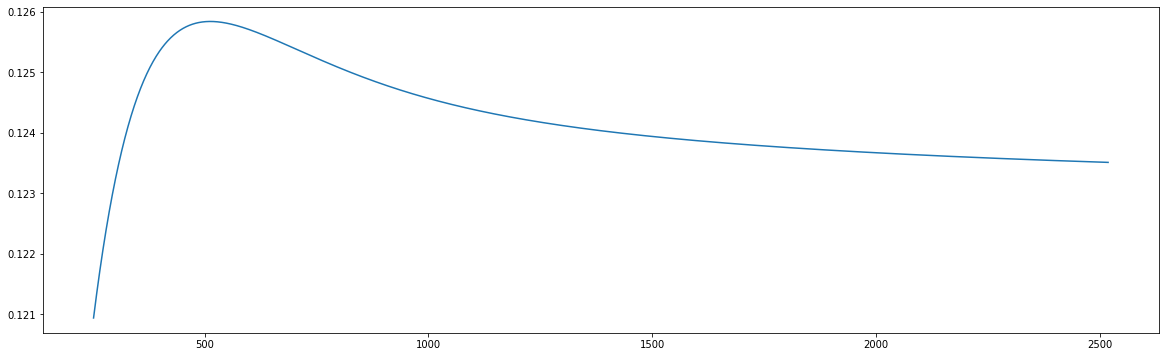

In [88]:
pre_curve = my.nss_curve(par)

t = np.arange(252, 2520)
r = pre_curve(t)

plt.figure(figsize=(20, 6))
plt.plot(t, r)
plt.show()

### Real Interest Rate from NTN-B bonds

* Once NTN-B is indexed to inflation, the interest rate paid additionally is the **real interest rate**.

In [89]:
ntnbs = df[df['symbol'] == 'NTN-B'].copy()

bonds = []

for _bond in ntnbs.to_dict('records'):
    REFDATE = datetime.datetime.strptime(_bond['refdate'], '%Y-%m-%d')
    _bond['maturity_date'] = datetime.datetime.strptime(_bond['maturity_date'], '%Y-%m-%d')
    _bond['issue_date'] = datetime.datetime.strptime(_bond['issue_date'], '%Y-%m-%d')
    _bond['calendar'] = MARKET_CALENDAR
    _bond['notional'] = 3702.299176
    _bond['yield'] = _bond['ref_yield']/100
    _bond['coupon_rate'] = 0.06
    _bond['coupon_frequency'] = 6
    
    bond = NTNB(**_bond)
    bonds.append(bond)

In [90]:
# ANBIMA's parameters for real interest rates
par = (0.0557, -0.0766, 0.1308, -0.0326, 2.0284, 1.0558)

ipca_discount_curve = my.nss_discount_curve(par)

In [91]:
errors = [100 * (b.theoretical_value(discount_curve=ipca_discount_curve) - b.spot_price) / b.spot_price for b in bonds]
for e in errors:
    print(f'{e: 1.4f}')

-0.4752
-0.5792
-0.6283
-0.4793
-0.3473
-0.4061
-0.4015
-0.4336
-0.4807
-0.5885
-0.4994
-0.4511
-0.3223


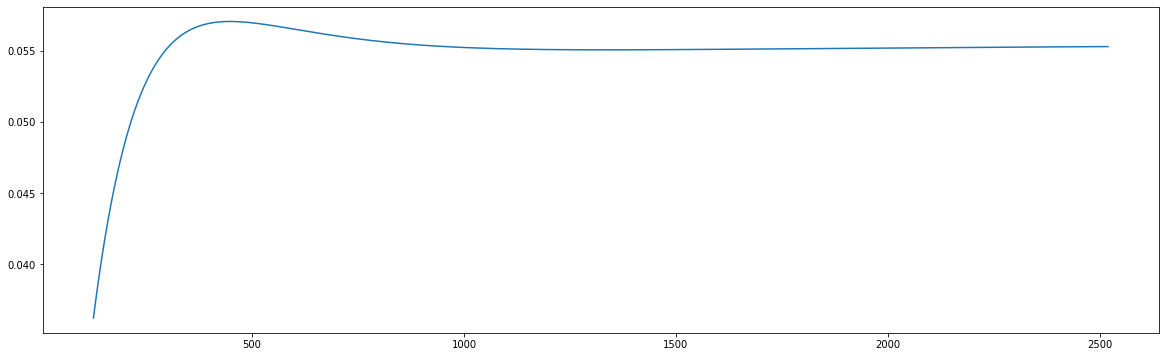

In [92]:
ipca_curve = my.nss_curve(par)

t = np.arange(126, 2520)
r = ipca_curve(t)

plt.figure(figsize=(20, 6))
plt.plot(t, r)
plt.show()

### Expected Inflation

* Having real and nominal rates, the future inflation can be estimated according to the following relation.

$$
(1 + c)(1 + i) = (1 + r)
$$

where

* $r$ is the nominal interest rate obtained from LTN and NTN-F bonds
* $c$ is the real interest rate obtained from NTN-B contracts
* $i$ is the resulting inflation

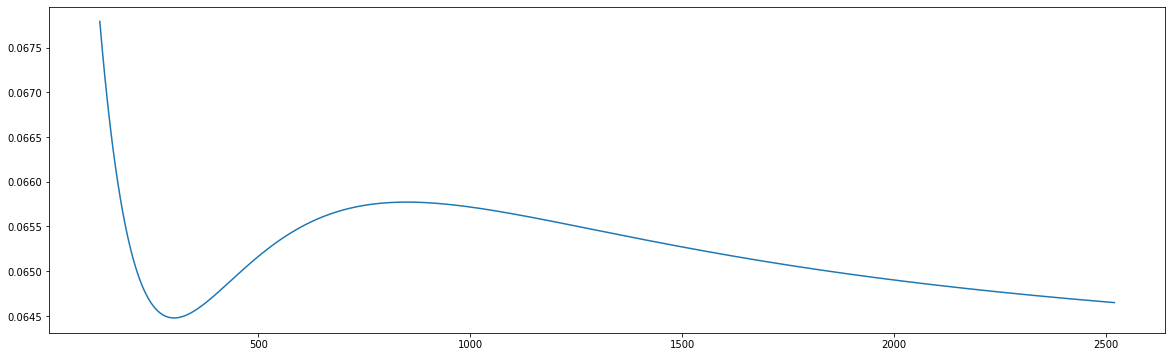

In [93]:
t = np.arange(126, 2520)
j = ipca_curve(t)
r = pre_curve(t)

f_r = (1 + r) ** (t/252)
f_j = (1 + j) ** (t/252)
i = (f_r/f_j) ** (252/t) - 1

plt.figure(figsize=(20, 6))
plt.plot(t, i)
plt.show()